In [136]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [122]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, AveragePooling2D, MaxPooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [26]:
import os
import tensorflow as tf

In [3]:
#mask image count = 690
#no mask image count = 686

In [4]:
mask_label = 'with_mask'
without_mask_label = 'without_mask'
label_names = [mask_label,without_mask_label]
dataset_dir = './face-mask-detector/dataset'

In [44]:
data = []
labels = []
for i in label_names:
  img_dir = os.path.join(dataset_dir,i)
  img_count = os.listdir(os.path.join(dataset_dir,i))
  for j in img_count:
    img_path = os.path.join(img_dir,j)
   
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    data.append(img)
    labels.append(i)


In [45]:
data = np.array(data,dtype='float32')

In [46]:
labels = np.array(labels)

In [19]:
# import pickle
# with open('image_np_array.pkl','wb') as f:
#     pickle.dump(data,f)
# with open('image_labels.pkl','wb') as f:
#     pickle.dump(labels,f)

In [47]:
bina = LabelBinarizer()

In [48]:
labels = bina.fit_transform(labels)

In [49]:
labels = to_categorical(labels)

In [50]:
data_tensor = tf.convert_to_tensor(data,dtype='float32')
label_tensor = tf.convert_to_tensor(labels)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,stratify=labels,
                                                   random_state=42,test_size=0.2)

In [65]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

In [52]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [68]:
base_model = MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

D:\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 11s 1us/step


In [70]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128,activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [142]:
final_model2 = Model(inputs=base_model.input,outputs=head_model)

In [144]:
final_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [145]:
for layer in base_model.layers:
    layer.trainable = False

In [146]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [147]:
opti = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [148]:
final_model2.compile(loss="binary_crossentropy", optimizer=opti,
	metrics=["accuracy"])


In [149]:
final_model2.fit(image_gen.flow(X_train_tensor,y_train_tensor,batch_size=BS),
               steps_per_epoch=X_train_tensor.shape[0]//BS,
               validation_data=(X_test_tensor,y_test_tensor),
               validation_steps=X_test_tensor.shape[0]//BS,
               epochs=EPOCHS)

Train for 34 steps, validate on 276 samples
Epoch 1/10
34/34 [==============================] - 197s 6s/step - loss: 0.0663 - accuracy: 0.9757 - val_loss: 0.0751 - val_accuracy: 0.9688
Epoch 2/10
34/34 [==============================] - 194s 6s/step - loss: 0.0675 - accuracy: 0.9710 - val_loss: 0.0713 - val_accuracy: 0.9727
Epoch 3/10
34/34 [==============================] - 193s 6s/step - loss: 0.0539 - accuracy: 0.9831 - val_loss: 0.0830 - val_accuracy: 0.9648
Epoch 4/10
34/34 [==============================] - 210s 6s/step - loss: 0.0530 - accuracy: 0.9822 - val_loss: 0.0606 - val_accuracy: 0.9766
Epoch 5/10
34/34 [==============================] - 195s 6s/step - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.0566 - val_accuracy: 0.9766
Epoch 6/10
34/34 [==============================] - 213s 6s/step - loss: 0.0462 - accuracy: 0.9831 - val_loss: 0.0597 - val_accuracy: 0.9727
Epoch 7/10
34/34 [==============================] - 240s 7s/step - loss: 0.0411 - accuracy: 0.9897 - val_loss:

In [150]:
final_model2.save('model2.h5')

In [151]:
predIdxs = final_model2.predict(X_test_tensor, batch_size=BS)


In [152]:
predIdxs

array([[8.44660997e-01, 1.55338973e-01],
       [9.99998331e-01, 1.71119416e-06],
       [6.01102458e-03, 9.93988991e-01],
       [9.99998569e-01, 1.37621794e-06],
       [7.38765637e-04, 9.99261200e-01],
       [5.26071489e-01, 4.73928541e-01],
       [1.00000000e+00, 8.37509118e-10],
       [3.67602140e-01, 6.32397830e-01],
       [9.96077240e-01, 3.92271718e-03],
       [6.34293974e-05, 9.99936581e-01],
       [4.62496013e-04, 9.99537587e-01],
       [7.25797657e-03, 9.92742062e-01],
       [9.99999285e-01, 7.00553528e-07],
       [1.00000000e+00, 3.89848243e-09],
       [1.23476842e-03, 9.98765230e-01],
       [1.12612303e-02, 9.88738775e-01],
       [9.99999642e-01, 4.06338955e-07],
       [7.05219945e-03, 9.92947817e-01],
       [1.00000000e+00, 2.40476927e-09],
       [5.19805821e-03, 9.94801998e-01],
       [9.99999881e-01, 1.62150187e-07],
       [5.19181376e-05, 9.99948025e-01],
       [9.99999881e-01, 1.67706332e-07],
       [9.99999881e-01, 1.66320163e-07],
       [9.999953

In [153]:
predIdxs = tf.argmax(predIdxs, axis=1)

print(classification_report(tf.argmax(y_test_tensor,axis=1), predIdxs,
	target_names=bina.classes_))

In [154]:
print(classification_report(tf.argmax(y_test_tensor,axis=1), predIdxs, target_names=bina.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      0.99      0.98       138
without_mask       0.99      0.96      0.97       138

    accuracy                           0.97       276
   macro avg       0.98      0.97      0.97       276
weighted avg       0.98      0.97      0.97       276



In [155]:
H = final_model.history

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

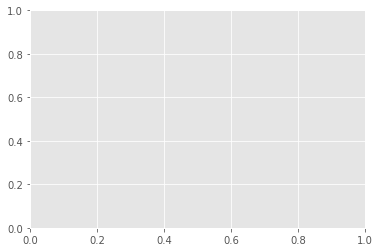

In [158]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('training_metrics.png')